In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import  matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# Loading Data

In [2]:
X_SIZE, Y_SIZE = (256, 256)

In [3]:
numpy_array_path = f"./classifcation_data_clean/aug_test_classification_labeled_numpy_{X_SIZE}"
train_x= np.load("{}/train_images_{}.npy".format(numpy_array_path, X_SIZE))
train_y= np.load("{}/train_labels_{}.npy".format(numpy_array_path, X_SIZE))

test_x= np.load("{}/test_images_{}.npy".format(numpy_array_path, X_SIZE))
test_y= np.load("{}/test_labels_{}.npy".format(numpy_array_path, X_SIZE))

In [4]:
print(f"Training:\t{len(train_x)} - {len(train_y)}")
print(f"Testing:\t{len(test_x)} - {len(test_y)}")

print(f"\nTrain_Images:\t{train_x.shape}")
print(f"Train_Labels:\t{train_y.shape}")

print(f"\nTrain_Images:\t{test_x.shape}")
print(f"Train_Labels:\t{test_y.shape}")

Training:	971 - 971
Testing:	178 - 178

Train_Images:	(971, 256, 256, 3)
Train_Labels:	(971, 1)

Train_Images:	(178, 256, 256, 3)
Train_Labels:	(178, 1)


# Neural Network

In [5]:
 model = tf.keras.models.Sequential([ 
     tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(X_SIZE, Y_SIZE, 3)),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.4),
     
     tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding="same"),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.4),
     
     tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.4),

     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(1, activation='sigmoid')
  ])

csv_logger = CSVLogger('training_metrics.csv')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy',
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()
            ]
)

In [6]:
model.summary()

In [7]:
history = model.fit(
    train_x, 
    train_y,
    batch_size = 64,
    verbose = 1,
    epochs = 50,
    validation_data = (test_x, test_y),
    callbacks = [csv_logger, early_stopping, model_checkpoint]
)

model.save('classification_model.h5')

Epoch 1/50
16/16 [==============================] - 11s 261ms/step - loss: 0.6837 - accuracy: 0.5654 - precision: 0.5829 - recall: 0.8940 - val_loss: 0.6843 - val_accuracy: 0.6910 - val_precision: 0.6910 - val_recall: 1.0000
Epoch 2/50
16/16 [==============================] - 2s 133ms/step - loss: 0.6565 - accuracy: 0.6220 - precision: 0.6145 - recall: 0.9435 - val_loss: 0.6616 - val_accuracy: 0.6742 - val_precision: 0.6901 - val_recall: 0.9593
Epoch 3/50
16/16 [==============================] - 2s 135ms/step - loss: 0.5291 - accuracy: 0.7796 - precision: 0.7411 - recall: 0.9558 - val_loss: 0.6070 - val_accuracy: 0.6854 - val_precision: 0.6936 - val_recall: 0.9756
Epoch 4/50
16/16 [==============================] - 2s 131ms/step - loss: 0.4290 - accuracy: 0.8177 - precision: 0.7988 - recall: 0.9187 - val_loss: 0.6504 - val_accuracy: 0.6573 - val_precision: 0.7768 - val_recall: 0.7073
Epoch 5/50
16/16 [==============================] - 2s 131ms/step - loss: 0.4124 - accuracy: 0.8239 - p

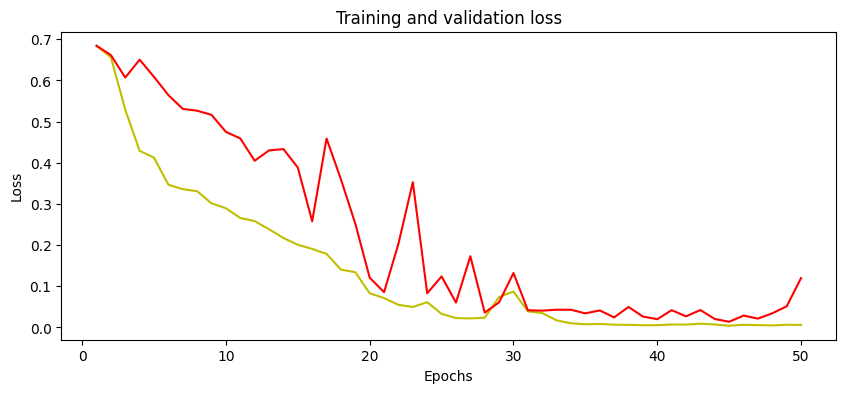

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validatoin loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# Confusion Matrix

6/6 [==============================] - 1s 97ms/step


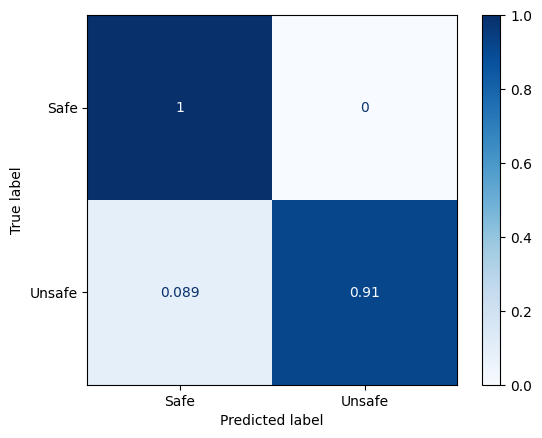

In [13]:
loaded_model = tf.keras.models.load_model('classification_model.h5')

pred_y = (loaded_model.predict(test_x) > 0.5).astype("int32")

confusion_matrix = confusion_matrix(test_y, pred_y, normalize='true')

class_labels = ['Safe', 'Unsafe']
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.show()